In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

Using TensorFlow backend.


### Load data, make a train and test set based on total reads per UTR
The test set contains UTRs with the highest overall sequencing reads with the idea that increased reads will more accurately reflect the true ribosome load of a given 5'UTR.

In [2]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Train model
Using the hyperparameter-optimised values.

In [ ]:
model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
                   inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.2)

Evaluate model. Return predicted mean ribosome load as a dataframe column labeled 'pred'.

In [ ]:
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

Save model

In [ ]:
model.save('./saved_models/my_special_model.hdf5')

### Plotting test results

In [3]:
model = keras.models.load_model('./saved_models/main_MRL_model.hdf5')

W0722 16:40:14.043200 4442613184 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 16:40:14.100955 4442613184 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 16:40:14.117521 4442613184 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 16:40:14.212733 4442613184 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0722 16:40:14.220067 4442613184 deprecati

In [4]:
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print 'r-squared = ', r

r-squared =  0.9338504476208073


In [5]:
atg = e_test[e_test['utr'].apply(lambda x: 'ATG' in x)]
n_atg = e_test[e_test['utr'].apply(lambda x: 'ATG' not in x)]

/usr/local/lib/python2.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


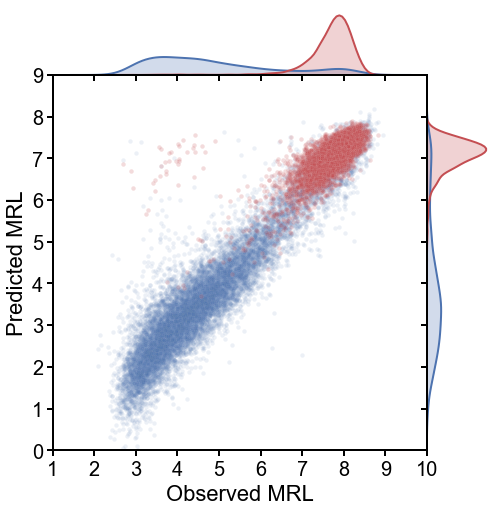

In [6]:
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="pred", data=atg, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha='0.1', edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = n_atg['rl'].values
g.y = n_atg['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha='0.2', color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig

## EVERYTHING BELOW THIS HEADER IS ADDED

### So, just what are these off-diagonal UTRS in the graph above?

In [15]:
### BELOW IS MY OWN SANDBOX

# so rl (that is RL, not R one!) is the observed MRL column, and pred is the predicted column

off_diagonals = e_test[(e_test['rl']<4.6)&(e_test['pred']>5.4)]
len(off_diagonals)

48

In [16]:
off_diagonals

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r6,r7,r8,r9,r10,r11,r12,r13,rl,pred
809,320,ATCGATCCACCCTGCATAGCAGGGAACTCTATTGTGCATGTTCGGATGCG,0.000044,0.000042,0.000025,0.000013,0.000009,0.000010,0.000004,0.000005,...,0.021431,0.024679,0.023677,0.021867,0.029297,0.029297,0.028727,0.042218,3.331041,6.045370
999,226582,AGCTTACTGAACCTGGTCGTGGAGGTATGCAGGAGGTATGTGCATGCCTG,0.000034,0.000036,0.000025,0.000013,0.000009,0.000009,0.000005,0.000006,...,0.029120,0.031509,0.030538,0.026672,0.043827,0.043827,0.042533,0.051309,4.065457,5.995093
1046,89012,GCGAGGGAACAAGAGCAAAGGAGAATCTAGGCCACATCTCTCGTCGTTCC,0.000024,0.000037,0.000028,0.000015,0.000011,0.000009,0.000006,0.000006,...,0.033772,0.035514,0.035510,0.033592,0.039144,0.039144,0.038410,0.035048,4.038996,7.305915
1733,85271,GTCCATGCAGAAAGTTCAGGTAAACTCGTGGGCGATAAGAATTTGGGAAC,0.000037,0.000033,0.000024,0.000012,0.000010,0.000007,0.000004,0.000004,...,0.024912,0.025271,0.019927,0.023506,0.035812,0.035812,0.030385,0.042090,3.502755,5.657888
1909,232479,ACAAAAACATTGACATGATCGGATACAGGCGGCGTACGGCATGCGCTACC,0.000030,0.000032,0.000024,0.000016,0.000008,0.000007,0.000004,0.000004,...,0.025004,0.026887,0.025049,0.024521,0.045485,0.045485,0.032901,0.031797,3.715876,5.623970
3279,115533,CACCGAGTCTTGCGGCCTAAATCCGTAGGGGTCTGGGTCCACGATTGTCC,0.000036,0.000031,0.000018,0.000009,0.000006,0.000007,0.000004,0.000004,...,0.027872,0.029664,0.025882,0.026299,0.035648,0.035648,0.031976,0.037537,3.450179,6.479451
3467,232027,CCATCAATTTATCACATAAAGCCCTGTGTGGGTTGTCTGCGCATACAGAA,0.000029,0.000028,0.000017,0.000010,0.000006,0.000006,0.000005,0.000005,...,0.031692,0.037771,0.034125,0.037183,0.047723,0.047723,0.039136,0.056973,4.217225,7.151853
3582,90322,CGCGCCGAACGCGCGACAAGCAAAGCACGACAGAACGTGCCCACTAAAGC,0.000035,0.000032,0.000018,0.000008,0.000007,0.000006,0.000005,0.000004,...,0.032290,0.026047,0.023872,0.028277,0.034306,0.034306,0.025561,0.041463,3.419108,6.397795
3974,265040,CCAGAAGATACAACCCGGGATTACTGGCGGTCCGATTAGAACTGATCAAG,0.000033,0.000034,0.000017,0.000010,0.000005,0.000005,0.000004,0.000004,...,0.025660,0.025103,0.025401,0.027429,0.032515,0.032515,0.039899,0.053005,3.598649,7.219923
4049,157141,CCTGCGTCTAGCCGGTGCGTGTAACGAATATCCTACCGTTGAAATACTAC,0.000029,0.000027,0.000019,0.000012,0.000005,0.000006,0.000003,0.000004,...,0.022889,0.029767,0.028933,0.027242,0.050658,0.050658,0.038351,0.045245,3.974110,6.926174


In [17]:
off_diagonals.to_csv('../off_diagonal_utrs.csv')

In [18]:
#How many of these contain 'ATG'?
atg_true = off_diagonals[off_diagonals['utr'].apply(lambda x: 'ATG' in x)]
atg_false = off_diagonals[off_diagonals['utr'].apply(lambda x: 'ATG' not in x)]

In [19]:
print len(atg_true)
print len(atg_false)

16
32


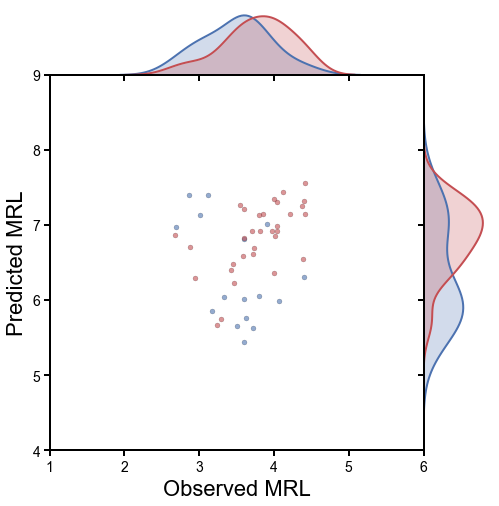

In [27]:
g = sns.JointGrid(x='rl', y="pred", data=atg_true, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
g.plot_joint(plt.scatter,s=25, color=c1, linewidth=0.2, alpha='0.6', edgecolor='black')
f = g.fig
ax = f.gca()
# ax.set_yticks(np.arange(0,9.01, 1));
# ax.set_yticklabels(range(10),size=20);
# ax.set_xticks(np.arange(1,10.01, 1));
# ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(4,9)
ax.set_xlim(1,6)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':'b'})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = atg_false['rl'].values
g.y = atg_false['pred'].values
g.plot_joint(plt.scatter, s=25, linewidth=0.2, alpha='0.6', color='r', edgecolor='black')
g.plot_marginals(sns.kdeplot, shade='r', **{'linewidth':2, 'color':'r'})
f = g.fig

In [42]:
def baseContent(seq,verbose=False):
    """returns dictionary of ATGC content in the input sequence, assumes all uppercase already"""
    d = {'A':0.0,'T':0.0,'G':0.0,'C':0.0}
    length = len(seq)
    s = seq.encode('ascii','ignore')
    for b in 'ATGC':
        d[b] = s.count(b) / length
    if verbose:
        print(d)
    return d

In [44]:
off_diagonals[u'utr'].apply(lambda s: baseContent(s))

809      {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
999      {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
1046     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
1733     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
1909     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
3279     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
3467     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
3582     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
3974     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
4049     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
4553     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
4749     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
5424     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
6500     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
8461     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
8845     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
9258     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
9571     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
9627     {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
10013    {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
10366    {u'A': 0, u'C': 0, u'T': 0, u'G': 0}
10584    {u'A': 0, u'C': 0, u'T': 